In [1]:
import os, pvl, shapely, itertools
from plio.io import io_controlnetwork
import networkx as nx
import matplotlib.pyplot as plt

os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"
os.environ["ISIS3DATA"] = "/usgs/cpkgs/isis3/data"
from pysis import isis
from pysis.exceptions import ProcessError

## Network and cube list to check

In [2]:
data_dir = '/work/users/jmapel/knoten/examples/europa/'
good_net = '11ESMORPHY01_Island9_Add.net'
bad_net = '11ESMORPHY01_Island9.net'
cube_list = '11ESMORPHY01_Island9.lis'

## Get the image serial numbers and footprints

In [3]:
cube_files = {}
labels = {}
for line in open(os.path.join(data_dir, cube_list)):
    cube_file = os.path.join(data_dir, line.strip())
    try:
        sn = isis.getsn(from_=cube_file).strip().decode('utf-8')
    except ProcessError as e:
        print(e.stderr)
        raise
    cube_files[sn] = cube_file
    labels[sn] = pvl.load(cube_file)

In [4]:
from shapely.wkt import dumps, loads
footprints = {}
for sn, file in cube_files.items():
    footprint_label = labels[sn]['Polygon']
    footprint_start_bytes = footprint_label['StartByte']
    footprint_bytes = footprint_label['Bytes']
    with open(file, 'rb') as fh:
        fh.seek(footprint_start_bytes - 1)
        footprint_binary = fh.read(footprint_bytes)
    footprints[sn] = loads(footprint_binary.decode('utf-8'))

## Create the overlap graph

In [5]:
footprint_graph = nx.Graph()
for sn in footprints.keys():
    footprint_graph.add_node(sn)
for sn1, sn2 in itertools.combinations(footprints.keys(), 2):
    if (footprints[sn1].intersects(footprints[sn2])):
        footprint_graph.add_edge(sn1, sn2)

## Create the network graph

In [6]:
cnet_df = io_controlnetwork.from_isis(os.path.join(data_dir, bad_net))
#cnet_df = io_controlnetwork.from_isis(os.path.join(data_dir, good_net))

In [7]:
network_graph = nx.Graph()
for point_id, group in cnet_df.groupby('id'):
    for sn1, sn2 in itertools.combinations(group['serialnumber'].unique(), 2):
        network_graph.add_edge(sn1, sn2)

## Find the overlaps without control points

In [8]:
bad_overlaps = []
for source, dest in footprint_graph.edges:
    if not network_graph.has_edge(source, dest):
        print(f"Image {source} and {dest} overlap but are not directly connected!")
        intersection = footprints[source].intersection(footprints[dest])
        print(f"  Image {source} overlap ratio: {intersection.area / footprints[source].area}")
        print(f"  Image {dest} overlap ratio: {intersection.area / footprints[dest].area}")
        bad_overlaps.append(intersection)

Image Galileo/SSI/04206267.13 and Galileo/SSI/04206267.26 overlap but are not directly connected!
  Image Galileo/SSI/04206267.13 overlap ratio: 0.04741618092597161
  Image Galileo/SSI/04206267.26 overlap ratio: 0.04802103744420974
Image Galileo/SSI/04206267.65 and Galileo/SSI/04206268.00 overlap but are not directly connected!
  Image Galileo/SSI/04206267.65 overlap ratio: 0.08328826088823132
  Image Galileo/SSI/04206268.00 overlap ratio: 0.08298887506906216


## Plot the overlaps without control points

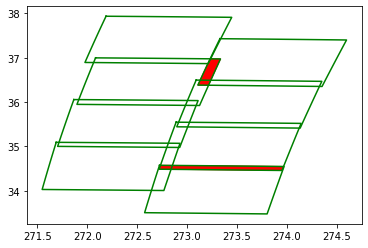

In [9]:
fig = plt.figure()
for _, footprint in footprints.items():
    for poly in footprint:
        plt.plot(*poly.exterior.xy, c='g')
for poly in bad_overlaps:
    plt.fill(*poly.exterior.xy, c='r')